### Importamos las librerias necesarias y cargamos los datos

In [ ]:
#-- Descomprimimos el dataset e instalamos los paquetes necesarios
# !rm -r fashion-mnist
!unzip fashion-mnist.zip
!pip install hiddenlayer

In [116]:
#-- Importamos las librerías
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import hiddenlayer as hl
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [117]:
#-- Buscamos las direcciones de cada archivo de imagen
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png') 

In [118]:
#-- Ordenamos los datos de forma aleatoria para evitar sesgos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [119]:
#-- Cargamos los datos de entrenamiento en listas
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [120]:
#-- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [121]:
#-- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

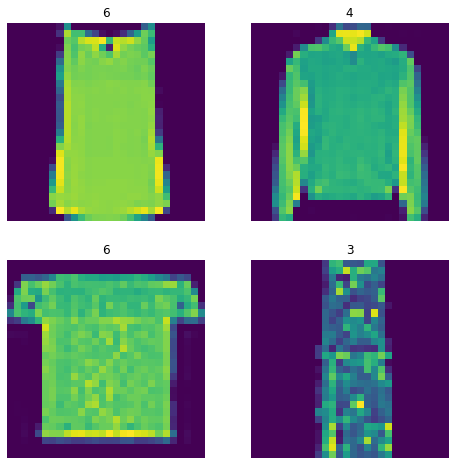

In [122]:
#-- Visualizamos los datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [123]:
#-- Convertimos las listas con los datos a tensores de torch
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [124]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### Arquitectura de la CNN

#### Definimos la matrix de confusión

In [ ]:
def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  return fig

#### Definimos la red

In [ ]:
#-- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=3),
  # ( (28-5+2*3)/1 ) + 1 = 30   -> 30*30*16
  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 30/2 = 15                 -> 15*15*16
  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=3),
  # ( (15-5+2*3)/1 ) + 1 = 18   -> 18*18*32
  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 18/2 = 9                 -> 9*9*32
  torch.nn.Dropout(p=0.2), 

  torch.nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=4),
  # ( (9-2+2*4)/1 ) + 1 = 16  -> 16*16*16
  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 16/2 = 8                 -> 8*8*16
  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(8*8*16, 10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(4, 4))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
#-- Definimos los criterios de evaluación y el optmizador

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


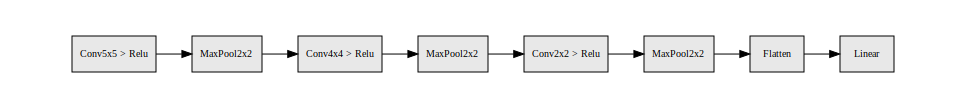

In [ ]:
#-- Visualizamos la estructura de nuestra CNN

hl.build_graph(model, torch.zeros([32,1,28,28]))

### Entrenamos nuestra CNN

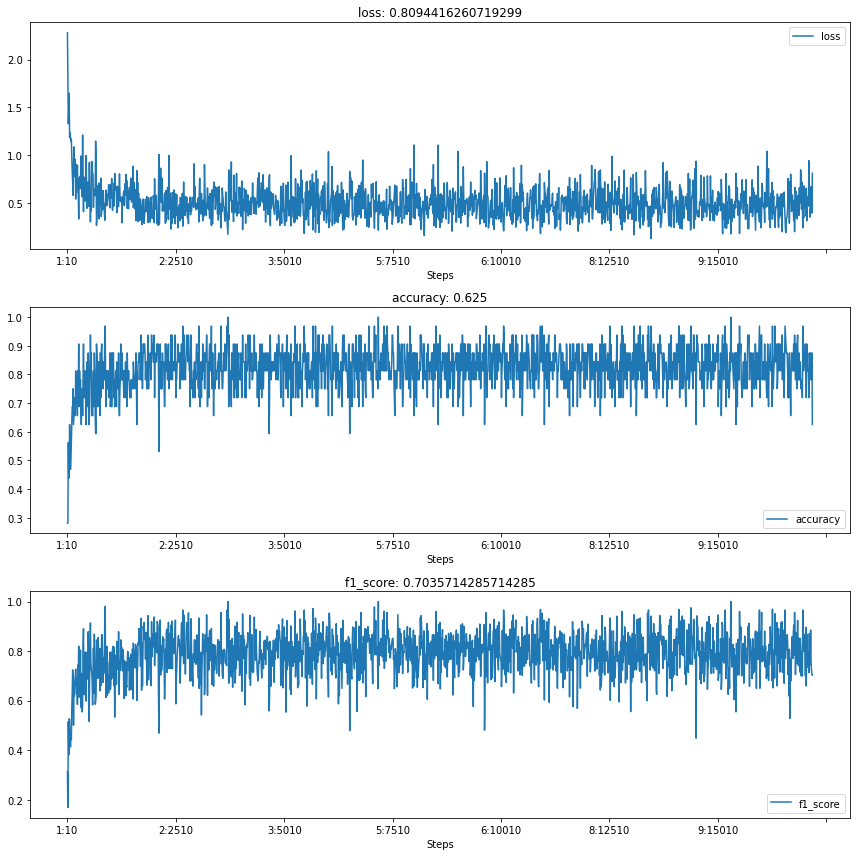

In [ ]:
#-- Entrenamos la CNN

from sklearn.metrics import f1_score

n_epoch = 10

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1_score=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1_score"])
          

#### Visualizando el mapa de características de la segunda capa convolucional

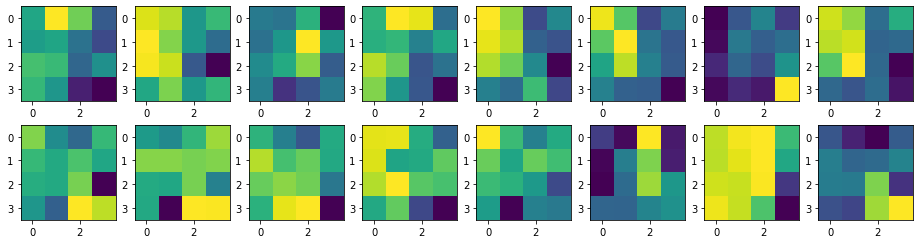

In [125]:
#-- Visualizando los mapas de características de la segunda capa convolucional
kernels = list(model.children())[4].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels[0].size(0)):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[0][i].squeeze())
    k += 1
plt.show()

#### Evaluamos nuestro modelo utilizando el set de testeo

In [131]:
model.eval()
Xvl = X_test.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.41, F1:0.86, Acc:0.85


#### Calculamos y mostramos la matrix de confusión 

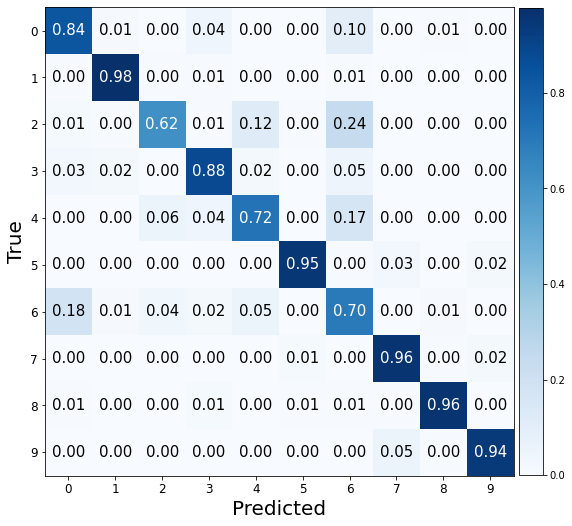

In [132]:
matrix = CM(Y_test, Y_pred, 10)

### Análisis de la CNN y descripción de los resultados

##### Utilizamos una CNN de 14 capas, con 3 de ellas siendo convolucionales y 3 de ellas del tipo Max Pooling  
- Una capa convolucional con 16 out_channel, un stride de 1, un padding de 3 y un kernel_size de 5 
- Una capa convolucional con 32 out_channel, un stride de 1, un padding de 3 y un kernel_size de 4  
- Una capa convolucional con 16 out_channel, un stride de 1, un padding de 4 y un kernel_size de 2  
- 3 capas de Max Pooling con un kernel_size de 2. 

##### Obtuvimos unos valores del set de validación de
- Loss = 0.41
- Accuracy = 0.85
- F1_score = 0.86
##### y una matrix de confusión que se muestra a continuación


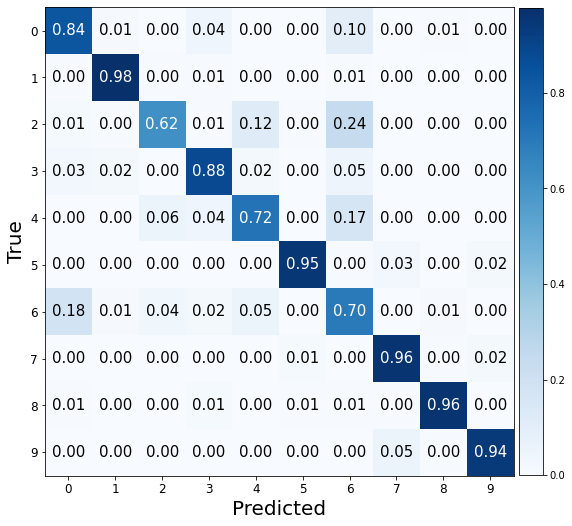

In [133]:
matrix

#### Resultados con los que, desafortunadamente, concluímos que el aprendizaje de nuestra CNN no fue completamente exitoso, o por lo menos, no el esperado por una CNN. Hecho debido, probablemente, a la complejidad tanto de los datos (prendas de ropa) como a la gran cantidad de capas de la red neuronal. Sin embargo, hubo varias clases de datos, como los __trousers, sneakers y bags__, en donde el modelo predijo con gran exactitud su categoría, mientras que cometió gran cantidad de errores prediciendo __shirts, pullovers y coats__. 